# Imaging at large angles

In [1]:
from pylab import *
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
import astropy.units as units
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time

%matplotlib notebook

In [2]:
ls /data/craco/ban115/test_data/

ddgrid/                       frb_d0_t3_a1_sninf_lm00/      nant20@
frb_d0_t0_a1_sn10_lm00/       frb_d0_t4_a1_sninf_lm00/      nant3/
frb_d0_t0_a1_sninf_lm00/      frb_d0_t9_a1_sninf_lm00/      nant30/
frb_d0_t0_a1_sninf_lm100200/  frb_d2_t0_a1_sninf_lm00/      nant36/
frb_d0_t0_a2_sninf_lm00/      frb_d2_t4_a1_sn10_lm300400/   old_tranpose/
frb_d0_t1_a1_sninf_lm00/      frb_d2_t4_a1_sninf_lm300400/  transpose_31204/
frb_d0_t2_a1_sninf_lm00/      frb_d3_t7_a1_sninf_lm00/


In [229]:
#fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
fits = '/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm100200/frb_d0_t0_a1_sninf_lm100200.fits'

# PSR B1933+16 data
#fits = '/data/craco/ban115/craco-python/notebooks/data/SB049048v2/cap_spi16_bm0_a1-12_k1-6_ps_tsoff/results/b00.uvfits'
#fits='/data/craco/ban115/test_data/nant3/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
values = craco.search_pipeline.get_parser().parse_args([])
print(values)
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --max-nbl 465 ")

Namespace(boxcar_weight='sum', calibration=None, cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_input=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=0, flag_ants=None, flag_chans=None, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', phase_center_filterbank=None, print_dm0_stats=False, run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, skip_blocks=0, subtract=True, target_input_rms=512, threshold=10.0, uv=None, verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')
parsing values --ndm 2 --max-nbl 465 


/data/craco/ban115/craft-github/src/craft/uvfits.py:100: UserWarning: Unknown int time in file. returning 1ms
  warnings.warn('Unknown int time in file. returning 1ms')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=515.0 2-3 uvpix=(254, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=515.0 2-3 uvpix=(253, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(253, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:140: UserWarning: Cannot grid things on U=0 or V=0 blid=1029.0 4-5 uvpix=(0, 251)
  warnings.warn

Upper registers [(3, 1), (4, 1), (34, 2), (35, 2), (36, 2), (37, 2), (38, 2), (39, 2), (40, 2), (41, 2), (42, 2), (43, 2), (44, 2), (45, 2), (46, 2), (87, 2), (88, 2), (89, 2), (90, 2), (91, 2), (92, 2), (93, 2), (94, 2), (95, 2), (96, 2), (97, 2), (98, 2), (99, 2), (100, 2), (101, 2), (102, 2), (103, 2)]
Lower registers [(1, 3), (1, 4), (2, 4), (3, 4), (3, 5), (3, 6), (4, 6), (4, 7), (2, 8), (4, 8), (2, 9), (3, 9), (4, 9), (5, 9), (3, 10), (5, 10), (7, 10), (3, 11), (5, 11), (6, 11), (7, 11), (7, 12), (8, 12), (8, 13), (9, 13), (7, 14), (8, 14), (9, 14), (8, 15), (8, 16), (9, 16), (2, 17)]


In [279]:
def pointsource(amp, lm, plan, noiseamp=0):
    '''
    Returns simulted visibilities for a point source with given amplitude at given value of lm =(l, m) in radians
    offset from the phase center
        
    :amp: amplitude
    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
    :plan: craco_plan to get all the goodies like UVWs and stuff from
    :noiseamp: add nois with tgiven ampliutude
    :returns: np.array of complex dtype with shape (nbl, nchan)
    '''
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs

        # TMS equation 3.7 - don't include 1/sqrt(1 - l*l - m*m) denomiator term for point sources#
        # TMS has a minus sign
        # Andre Offringa's simulator has a plus sign
        # go figure?
        # Without the minus sign also matches miriad
        vis = amp*np.exp(2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if noiseamp > 0:
            vishape = vis.shape
            noise = noiseamp*(np.random.randn(*vishape) + 1j*np.random.randn(*vishape))
            vis += noise

        dout[ibl, :] = vis

    return dout

In [280]:
lm = (0,0.1)
# The fits files with lm100200 has l,m offsets of 100,200 arcseconds respecitvely. Let's see if we can reproduce it.
lmarcsec = np.array((100,200))
lm = np.sin(np.radians(lmarcsec/3600))
#lm=(0.01,0.02)
#lm = np.sin(np.radians([0.5,0.5]))
vissim = pointsource(1, lm, plan)
print('lm', lm)

lm [0.00048481 0.00096963]


<IPython.core.display.Javascript object>


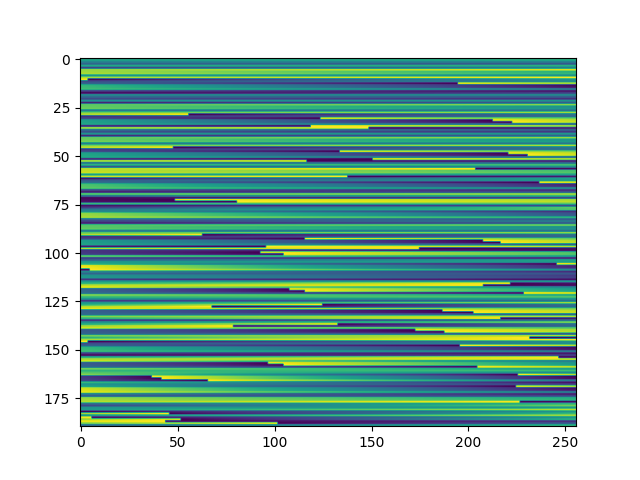

In [281]:
figure()
imshow(np.angle(vissim))

In [283]:
uvws = []
freqs = plan.freqs

for ibl, blid in enumerate(plan.baseline_order):       
    # baselines in seconds
    uvw_sec = np.array(plan.baselines[blid][:3])

    # convert UVW coordinates to wavelegths
    u = uvw_sec[0]*freqs
    v = uvw_sec[1]*freqs
    w = uvw_sec[2]*freqs
    uvws.append((u,v,w))
    
uvws = np.array(uvws)
uvws.shape

(190, 3, 256)

<IPython.core.display.Javascript object>


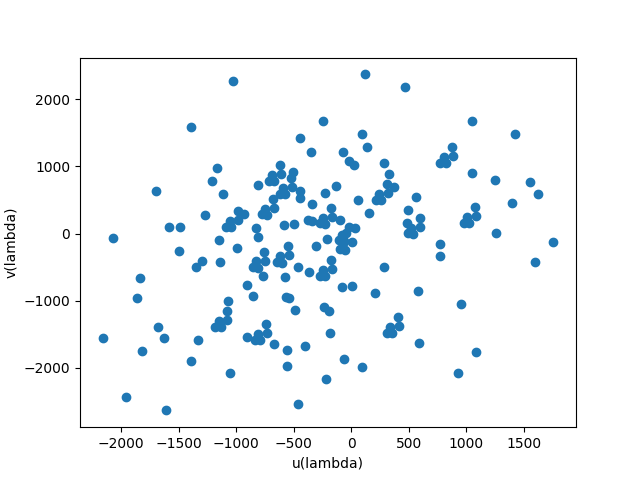

Text(0, 0.5, 'v(lambda)')

In [284]:
figure()
scatter(uvws[:,0,0],uvws[:,1,0])
xlabel('u(lambda)')
ylabel('v(lambda)')


<IPython.core.display.Javascript object>


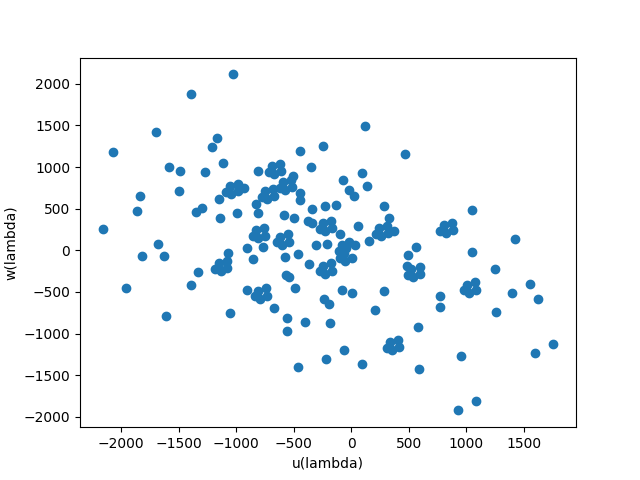

Text(0, 0.5, 'w(lambda)')

In [286]:
figure()
scatter(uvws[:,0,0],uvws[:,2,0])
xlabel('u(lambda)')
ylabel('w(lambda)')

<IPython.core.display.Javascript object>


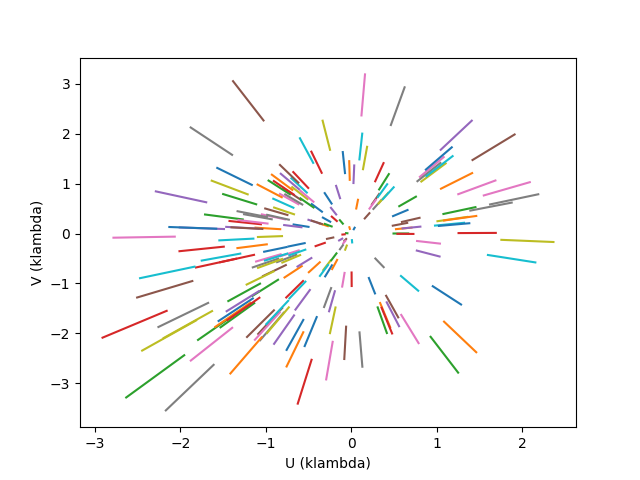

In [288]:
figure()
f.plot_baselines()

In [291]:
f.baselines.keys()


dict_keys([258.0, 259.0, 515.0, 260.0, 516.0, 772.0, 261.0, 517.0, 773.0, 1029.0, 262.0, 518.0, 774.0, 1030.0, 1286.0, 263.0, 519.0, 775.0, 1031.0, 1287.0, 1543.0, 264.0, 520.0, 776.0, 1032.0, 1288.0, 1544.0, 1800.0, 265.0, 521.0, 777.0, 1033.0, 1289.0, 1545.0, 1801.0, 2057.0, 266.0, 522.0, 778.0, 1034.0, 1290.0, 1546.0, 1802.0, 2058.0, 2314.0, 267.0, 523.0, 779.0, 1035.0, 1291.0, 1547.0, 1803.0, 2059.0, 2315.0, 2571.0, 268.0, 524.0, 780.0, 1036.0, 1292.0, 1548.0, 1804.0, 2060.0, 2316.0, 2572.0, 2828.0, 269.0, 525.0, 781.0, 1037.0, 1293.0, 1549.0, 1805.0, 2061.0, 2317.0, 2573.0, 2829.0, 3085.0, 270.0, 526.0, 782.0, 1038.0, 1294.0, 1550.0, 1806.0, 2062.0, 2318.0, 2574.0, 2830.0, 3086.0, 3342.0, 271.0, 527.0, 783.0, 1039.0, 1295.0, 1551.0, 1807.0, 2063.0, 2319.0, 2575.0, 2831.0, 3087.0, 3343.0, 3599.0, 272.0, 528.0, 784.0, 1040.0, 1296.0, 1552.0, 1808.0, 2064.0, 2320.0, 2576.0, 2832.0, 3088.0, 3344.0, 3600.0, 3856.0, 273.0, 529.0, 785.0, 1041.0, 1297.0, 1553.0, 1809.0, 2065.0, 2321.0, 25

In [292]:
d = f.baselines[258.0]
blid = d['BASELINE']
blid

258.0

In [293]:
u,v,w = d['UU'],d['VV'],d['WW']
freqs = plan.freqs
ulam, vlam, wlam = u*freqs, v*freqs, w*freqs


In [294]:
idx = np.where(plan.baseline_order == blid)[0][0]
idx

0

In [295]:
vissim[idx,:].shape

(256,)

In [296]:
vissim.shape

(190, 256)

In [297]:
d.data.shape

(1, 1, 256, 1, 3)

In [298]:
visc = d.data[0,0,:,0,0] + 1j*d.data[0,0,:,0,1]

In [299]:
np.all(f.hdulist[0].data['BASELINE'] == plan.baseline_order)

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [300]:
f.baselines

{258.0: (3.9145554e-08, 1.1910918e-07, 9.108905e-08, 258.0, 2459010.500000119, array([[[[[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
          [[0.      , 0.      , 0.001728]],
 
  

In [303]:
#alldata = f.hdulist[0].data['DATA'][:,0,0,:,0,0] + 1j*f.hdulist[0].data['DATA'][:,0,0,:,0,1]
nbl = len(plan.baseline_order)
nchan=256
alldata = np.zeros((nbl, nchan), dtype=np.complex64)
blids = f.hdulist[0].data['BASELINE']
for i, ibl in enumerate(plan.baseline_order):
    idx = np.where(blids == ibl)[0][0]
    print(idx)
    alldata[i, :] = f.hdulist[0].data['DATA'][idx,0,0,:,0,0] + 1j*f.hdulist[0].data['DATA'][idx,0,0,:,0,1]



0
1
3
6
10
15
21
28
36
45
55
66
78
91
105
120
136
153
171
2
4
7
11
16
22
29
37
46
56
67
79
92
106
121
137
154
172
5
8
12
17
23
30
38
47
57
68
80
93
107
122
138
155
173
9
13
18
24
31
39
48
58
69
81
94
108
123
139
156
174
14
19
25
32
40
49
59
70
82
95
109
124
140
157
175
20
26
33
41
50
60
71
83
96
110
125
141
158
176
27
34
42
51
61
72
84
97
111
126
142
159
177
35
43
52
62
73
85
98
112
127
143
160
178
44
53
63
74
86
99
113
128
144
161
179
54
64
75
87
100
114
129
145
162
180
65
76
88
101
115
130
146
163
181
77
89
102
116
131
147
164
182
90
103
117
132
148
165
183
104
118
133
149
166
184
119
134
150
167
185
135
151
168
186
152
169
187
170
188
189


In [304]:
blid = f.hdulist[0].data['BASELINE'][0]
blid

258.0

In [305]:
alldata.shape

(190, 256)

In [306]:
def grid(plan, din, uvcell, npix):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
        
    g = np.zeros((npix,npix), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        #w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        pivot = npix // 2
        upix = np.round(u/uvcell[0] ).astype(int)
        vpix = np.round(v/uvcell[1] ).astype(int)
        for ichan, (up,vp) in enumerate(zip(upix,vpix)):
            g[pivot+vp,pivot+up] += din[ibl,ichan]
            g[pivot-vp,pivot-up] += np.conj(din[ibl,ichan])
        

        
        
    return g

def doimage(g):
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g)))

<IPython.core.display.Javascript object>


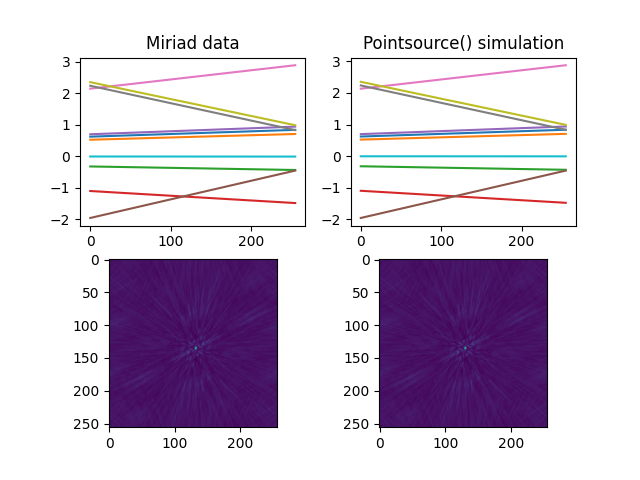

In [307]:

nant = 20
nbl = 20*19//2
fig,ax = subplots(2,2)
ax[0,0].plot(np.angle(alldata[:10,:].T))
ax[0,1].plot(np.angle(vissim[:10].T))
ax[0,0].set_title('Miriad data')
ax[0,1].set_title('Pointsource() simulation')
ax[1,0].imshow(doimage(grid(plan, alldata[:nbl,:], plan.uvcell, plan.npix)).real)
ax[1,1].imshow(doimage(grid(plan, vissim, plan.uvcell, plan.npix)).real)


<IPython.core.display.Javascript object>


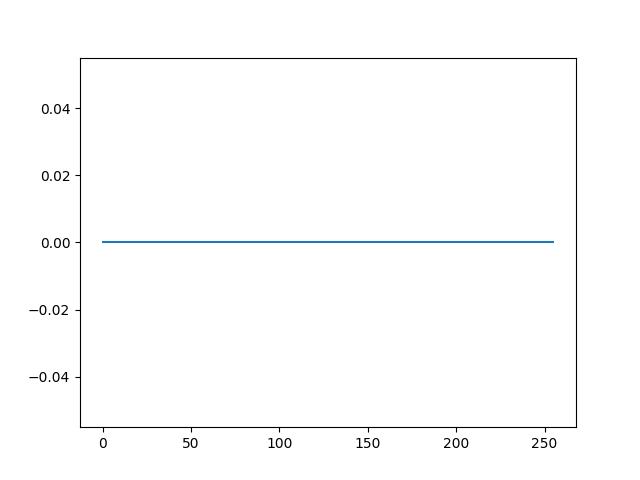

In [308]:
figure()
plot(np.degrees(np.angle(visc)))
#plot(np.degrees(np.angle(np.conj(vissim[idx,:]))),'x')

<IPython.core.display.Javascript object>


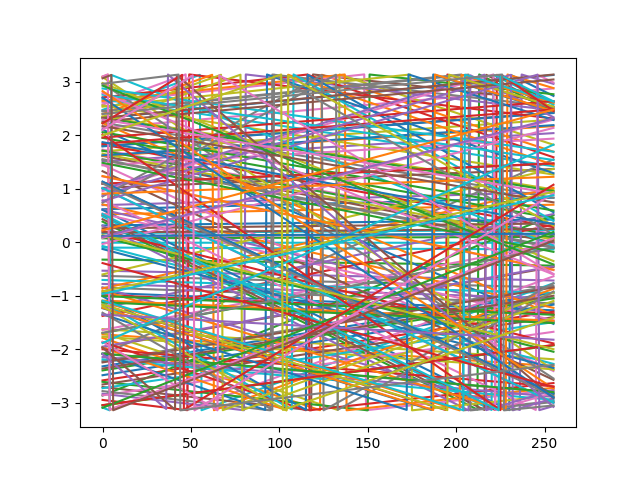

In [309]:
figure()
_ = plot(np.angle(vissim).T)

In [310]:
plan.uvcell

(23.883149945277932, 29.081114924911077)

lm=[0.01047178 0.00872654]


<IPython.core.display.Javascript object>


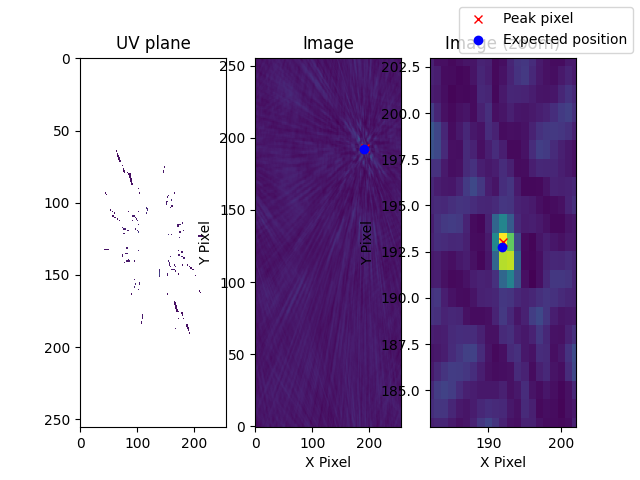

maxpix (193, 192)


In [314]:

# use plan cell size
uvcell = plan.uvcell

# use plan npix
npix=plan.npix

#    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
psi = Angle('0.6d') # offset degrees - RA direction
theta = Angle('0.5d') # offset degrees - dec direction
expected_dec = plan.phase_center.dec + theta # not sure why I need a negative here
# RA needs to be decremented by source cos dec
expected_ra = np.degrees(plan.phase_center.ra.rad - psi.rad/np.cos(expected_dec.rad))
expected_pos = SkyCoord(expected_ra, expected_dec, unit='deg')
# What did I expect the pixel location to be, given the expected position?
expected_pixel = plan.wcs.world_to_pixel(expected_pos)

lm = np.sin([psi.rad, theta.rad])
print(f'lm={lm}')
#lm=(0.01,0.02)
#lm = (0,0)
#lm = (0,0)
peak = 97280.0
vissim = pointsource(1, lm, plan)

fig,ax = subplots(1,3)
g = grid(plan, vissim, uvcell, npix)/np.prod(vissim.shape)/2 # Scales image to 1 for phase center
img = doimage(g)
gimg = abs(g)
gimg[gimg==0] = np.nan
maxpix = np.unravel_index(np.argmax(img.real), img.shape)
print('maxpix', maxpix)
ymax,xmax = maxpix
extents = (xmax -10, xmax+10, ymax-10, ymax+10)
#xtents=None
ax[0].imshow(gimg, aspect='auto')
ax[0].set_title("UV plane")

ax[1].imshow(img.real,aspect='auto', origin='lower')
ax[1].plot(xmax,ymax, 'rx')
ax[1].plot(expected_pixel[0], expected_pixel[1], 'bo')
ax[1].set_xlabel('X Pixel')
ax[1].set_ylabel('Y Pixel')
ax[1].set_title("Image")


ax[2].imshow(img.real,aspect='auto', origin='lower')
line1, = ax[2].plot(xmax,ymax, 'rx')
# (Because matplotlib pixels are centered on 0, we have to add 0.5 pixels) to get them to line up
# if you set the position to 0,0
line2, = ax[2].plot(expected_pixel[0]+0.5, expected_pixel[1]+0.5, 'bo') 
ax[2].set_xlabel('X Pixel')
ax[2].set_ylabel('Y Pixel')
ax[2].set_xlim(xmax-10,xmax+10)
ax[2].set_ylim(ymax-10,ymax+10)
ax[2].set_title("Image (zoom)")

figlegend((line1,line2),('Peak pixel','Expected position'))
        

<IPython.core.display.Javascript object>


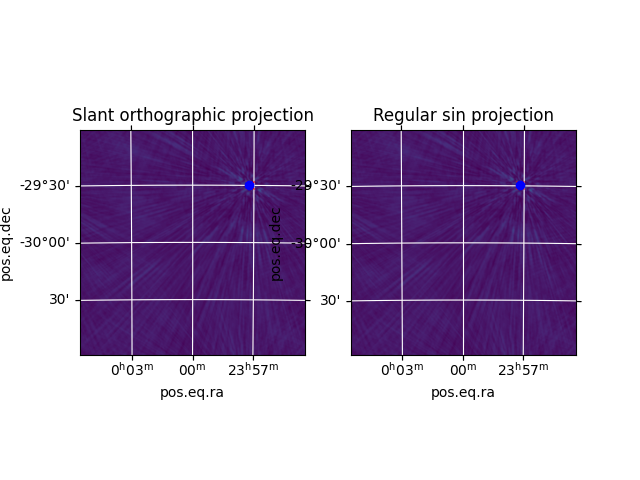

Text(0.5, 1.0, 'Regular sin projection')

In [315]:
from astropy.wcs import WCS
mywcs = WCS(naxis=2)
mywcs.wcs.crpix = [npix/2,npix/2] # honestly, I dont' understand if we need to +0.5 or not, or 1. 
mywcs.wcs.crval = [plan.phase_center.ra.deg, plan.phase_center.dec.deg]
mywcs.wcs.ctype = ['RA---SIN','DEC--SIN']
mywcs.wcs.cunit = ['deg','deg']
mywcs.wcs.cdelt = [-plan.lmcell[0].deg, plan.lmcell[1].deg]
import matplotlib.pyplot as plt
figure()

plt.subplot(1,2,1, projection=plan.wcs)
plt.imshow(img.real)
plt.grid(color='white', ls='solid')
plt.plot(xmax,ymax, 'rx')
plt.plot(expected_pixel[0], expected_pixel[1], 'bo')
plt.title('Slant orthographic projection')

plt.subplot(1,2,2,projection=mywcs)
plt.imshow(img.real)
plt.grid(color='white', ls='solid')
plt.plot(xmax,ymax, 'rx')
plt.plot(expected_pixel[0], expected_pixel[1], 'bo')
plt.title('Regular sin projection')


In [317]:
plan.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  -30.0  
CRPIX : 128.5  128.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.009371110562709875  0.007696116166827541  
NAXIS : 0  0

In [318]:
# there's some extra stuff in GETPV - that Steve Told me to put in to make it a slant orthographic projection
# see Ord et al. 2020 I t
plan.wcs.wcs.get_pv()

[(2, 1, 0.2289379053763232), (2, 2, 0.044650010138820743)]

In [319]:
# CRPIX is 128.5,128.5, but if you put do pixel_to_world(127.5,127.5) you get CRVAL back
# So there's a +-1 added because of the FITS convention. SIGH
plan.wcs.pixel_to_world(127.5,127.5)

<SkyCoord (ICRS): (ra, dec) in deg
    (4.96116543e-31, -30.)>

In [320]:
# similarly, wth the WCS as it stands, if you put in the phase center, what do you get?
# you get 127.5, 17.5
plan.wcs.world_to_pixel(plan.phase_center)

(array(127.5), array(127.5))

In [321]:
wcs_pos = plan.wcs.pixel_to_world(xmax-1,ymax-1) 
wcs_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (359.31488473, -29.50204621)>

In [322]:
expected_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (359.31062668, -29.5)>

In [323]:
ra_err = expected_pos.ra - wcs_pos.ra
ra_err

<Angle -0.00425806 deg>

In [324]:
dec_err = expected_pos.dec - wcs_pos.dec
dec_err

<Angle 0.00204621 deg>

In [325]:
# image resolution
plan.lmcell.arcsec

array([33.73599803, 27.7060182 ])

In [326]:
plan.wcs.world_to_pixel(expected_pos)

(array(191.39535318), array(192.26330045))

In [327]:
xmax, ymax

(192, 193)

In [328]:
# teh flat WCS is worse than plan.wcs, ish.
mywcs.world_to_pixel(expected_pos)

(array(191.02501812), array(191.73250789))

# Sweep in RA/Dec

In [331]:
#    :lm: tuple of l,m as direction cosines i.e. l=sin(psi), m=sin(theta)
expected_pixels = []
expected_pixels_flat = []
max_value = []

actual_pixels = []
angrange = np.arange(-0.7,0.7,0.1)
for psi in angrange:
    expected_pixels.append([])
    actual_pixels.append([]) 
    expected_pixels_flat.append([])
    max_value.append([])
    for theta in angrange:        
        psi = Angle(psi, unit='deg') # offset degrees - RA direction
        theta = Angle(theta,unit='deg') # offset degrees - dec direction
        expected_dec = plan.phase_center.dec + theta # not sure why I need a negative here
        expected_ra = np.degrees(plan.phase_center.ra.rad - psi.rad/np.cos(expected_dec.rad))
        expected_pos = SkyCoord(expected_ra, expected_dec, unit='deg')
        expected_pixel = plan.wcs.world_to_pixel(expected_pos)
        expected_pixel2 = mywcs.world_to_pixel(expected_pos)


        lm = np.sin([psi.rad, theta.rad])
        vissim = pointsource(1, lm, plan)
        g = grid(plan, vissim, uvcell, npix)/np.prod(vissim.shape)/2 # Scales image to 1 for phase center
        img = doimage(g)
        maxpix = np.unravel_index(np.argmax(img.real), img.shape)
        actual_pixels[-1].append(maxpix)
        expected_pixels[-1].append(expected_pixel)
        expected_pixels_flat[-1].append(expected_pixel2)
        max_value[-1].append(img.real.max())
        


In [332]:
expected_pixels = np.array(expected_pixels)
expected_pixels_flat = np.array(expected_pixels_flat)

actual_pixels = np.array(actual_pixels)

In [333]:
expected_pixels.shape

(14, 14, 2)

In [334]:
actual_pixels.shape

(14, 14, 2)

In [335]:
expected_pixels[0,0,:]

array([52.59518006, 36.27400774])

In [336]:
actual_pixels[0,0,:] # is transposed because of how unravel index works

array([36, 54])

<IPython.core.display.Javascript object>


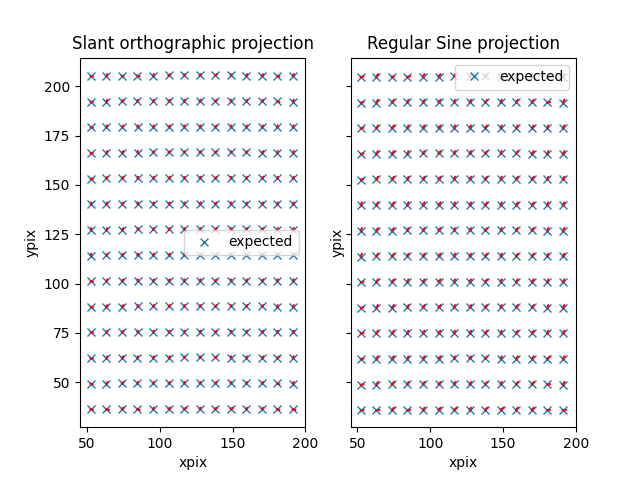

Text(0.5, 1.0, 'Regular Sine projection')

In [337]:

def plot_diff(ax, expected_pixels, actual_pixels):
    ax.plot(expected_pixels[...,0].flatten(), expected_pixels[...,1].flatten(), 'x', label='expected')
    for i in range(np.array(actual_pixels.shape[0:2]).prod()): 
        x1 = expected_pixels[...,0].flatten()[i]
        y1 = expected_pixels[...,1].flatten()[i]
        x2 = actual_pixels[...,1].flatten()[i]
        y2 = actual_pixels[...,0].flatten()[i]
        ax.plot([x1,x2],[y1,y2],'r')
        
    ax.set_xlabel('xpix')
    ax.set_ylabel('ypix')
    ax.legend()


fig, ax = subplots(1,2,sharex=True,sharey=True)
plot_diff(ax[0], expected_pixels, actual_pixels)
plot_diff(ax[1], expected_pixels_flat, actual_pixels)
ax[0].set_title('Slant orthographic projection')
ax[1].set_title('Regular Sine projection')



<IPython.core.display.Javascript object>


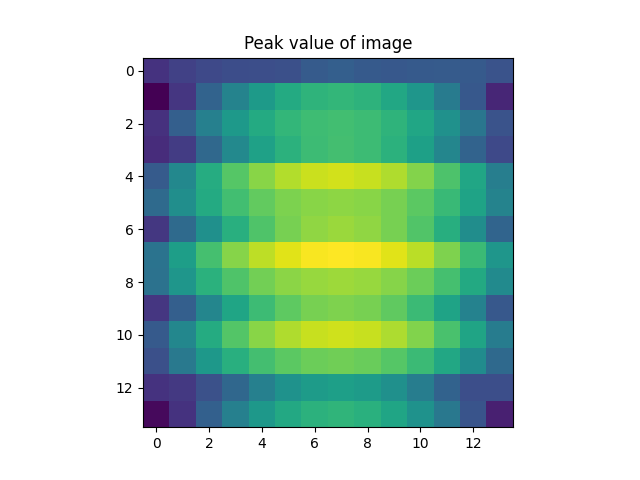

Text(0.5, 1.0, 'Peak value of image')

In [338]:
figure()
imshow(max_value)
title('Peak value of image')

<IPython.core.display.Javascript object>


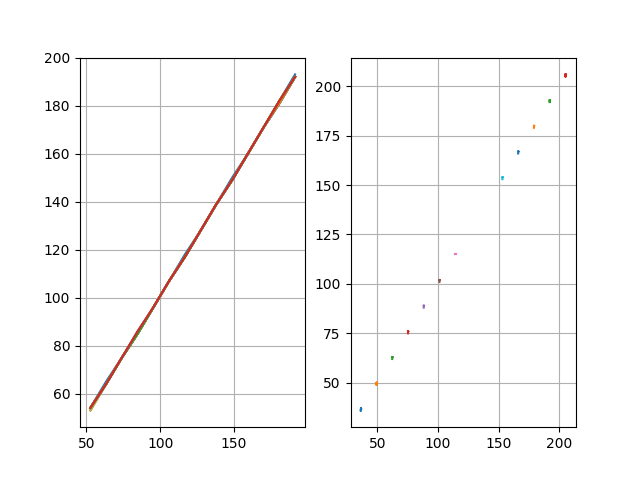

In [339]:
fig,ax = subplots(1,2)
ax[0].plot(expected_pixels[...,0],actual_pixels[...,1])
ax[1].plot(expected_pixels[...,1],actual_pixels[...,0])
ax[0].grid(True)
ax[1].grid(True)


# Doing something else - check what changing cell size does to peak value

In [343]:


for c in (2,5,10,15,20,30,40):
    for npix in (256,512,1024,2048,4096):
        uvcell=(c,c)
        try:
            g = grid(plan, vissim, uvcell, npix)
            img = doimage(g)
            print(f'c={c} npix={npix} max={img.real.max()/peak}')
        except:
            print(f'Couldnt grid c={c} npix={npix}')
        

Couldnt grid c=2 npix=256
Couldnt grid c=2 npix=512
Couldnt grid c=2 npix=1024
Couldnt grid c=2 npix=2048
c=2 npix=4096 max=0.9419964573510069
Couldnt grid c=5 npix=256
Couldnt grid c=5 npix=512
Couldnt grid c=5 npix=1024
c=5 npix=2048 max=0.9348148566014899
c=5 npix=4096 max=0.9886914121258706
Couldnt grid c=10 npix=256
Couldnt grid c=10 npix=512
c=10 npix=1024 max=0.9107512760273598
c=10 npix=2048 max=0.9626101269751772
c=10 npix=4096 max=0.9626101269751771
Couldnt grid c=15 npix=256
c=15 npix=512 max=0.9087011424647391
c=15 npix=1024 max=0.9087011424647391
c=15 npix=2048 max=0.9151740885892374
c=15 npix=4096 max=0.9203076560707538
Couldnt grid c=20 npix=256
c=20 npix=512 max=0.8148127625723757
c=20 npix=1024 max=0.8609387114890805
c=20 npix=2048 max=0.8609387114890806
c=20 npix=4096 max=0.863227898722146
c=30 npix=256 max=0.7024111115192497
c=30 npix=512 max=0.70241111151925
c=30 npix=1024 max=0.7068394313327651
c=30 npix=2048 max=0.7109530523443016
c=30 npix=4096 max=0.711326403727

In [344]:
sum(abs(vissim))

48640.0

In [345]:
np.prod(vissim.shape)

48640

In [346]:
def degrid(plan, lm, uvcell):
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    l,m = lm
        
    nbl = plan.nbl
    freqs = plan.freqs
    nf = len(freqs)
    assert np.all(freqs > 500e6), 'Invalid frequencies'
    
    l, m = lm
    dout = np.empty((nbl, nf), dtype=np.complex64)
    for ibl, blid in enumerate(plan.baseline_order):       
        # baselines in seconds
        uvw_sec = np.array(plan.baselines[blid][:3])
        
        # convert UVW coordinates to wavelegths
        u = uvw_sec[0]*freqs
        v = uvw_sec[1]*freqs
        w = uvw_sec[2]*freqs
        
        #vis = np.exp(-2j*np.pi*(u*l + v*m + w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        if uvcell is not None:
            u = np.round(u/uvcell[0])*uvcell[0]
            v = np.round(v/uvcell[1])*uvcell[1]
            
        devis = np.exp(-2j*np.pi*(u*l + v*m + 0*w*(np.sqrt(1.0 - l*l - m*m) - 1.0)))
        dout[ibl,:] = devis
    return dout

vissimdg = degrid(plan,lm,uvcell=None)
print(np.sum(np.conj(vissimdg)*vissim)/np.prod(vissim.shape))

(0.018475614095989027-0.005261095574027613j)


<IPython.core.display.Javascript object>


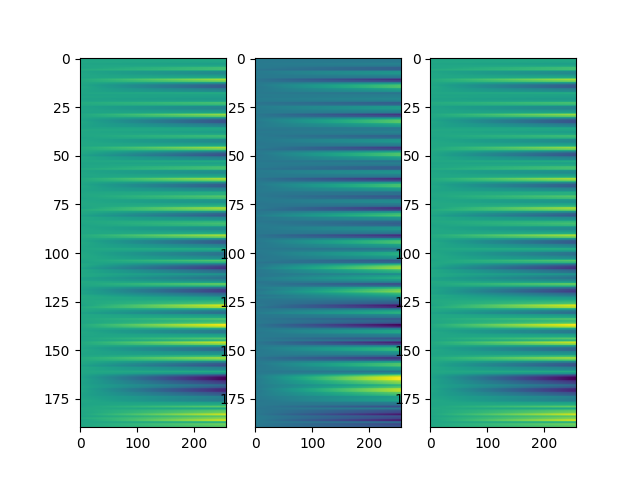

In [347]:
def myang(d):
    return np.degrees(np.unwrap(np.angle(d)))
fig,ax = subplots(1,3)
ax[0].imshow(myang(vissim), aspect='auto')
ax[1].imshow(myang(vissimdg), aspect='auto')
ax[2].imshow(myang(vissim) - myang(vissimdg), aspect='auto')


<IPython.core.display.Javascript object>


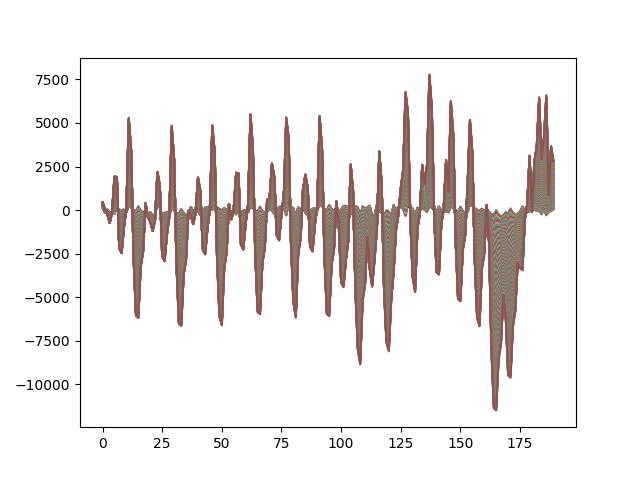

In [348]:
figure()
x = myang(vissim) - myang(vissimdg)
plot(x)